### **Proyecto Médico · Predicción de Enfermedad Cardíaca**  

 **PARTE 1 · ANÁLISIS CONCEPTUAL**  

---

### 1. Objetivo comercial (Hospital / Sistema de Salud)  
| Dimensión | Detalle clínico-operativo |
|-----------|--------------------------|
| **Reducción de mortalidad y morbilidad** | Identificar de forma temprana a pacientes en riesgo de cardiopatía isquémica para iniciar intervenciones preventivas (cambios en estilo de vida, terapia farmacológica, cateterismo oportuno). |
| **Optimización de recursos** | Priorizar camas UCI, laboratorios y tiempos de quirófano para pacientes de alto riesgo, evitando hospitalizaciones y re-ingresos evitables. |
| **Costos y eficiencia** | Disminuir el gasto por eventos adversos (IAM, insuficiencia cardiaca), reduciendo estadías prolongadas y penalizaciones por rehospitalizaciones. |
| **Calidad y experiencia del paciente** | Proveer decisiones informadas al personal clínico → mayor satisfacción y cumplimiento con estándares de salud pública. |

> **Métrica de éxito:** reducción del ≥ 15 % en re-ingresos cardíacos a 30 días y descenso del coste medio por paciente con riesgo alto.  

---

### 2. Objetivo de minería de datos  
> **Preguntas analíticas**  
> 1. ¿Cuál es la probabilidad 
$P(\mathrm{condition}=1 \mid X)$ 
 de que un paciente presente enfermedad cardíaca?  
> 2. ¿Qué factores explican mejor dicha probabilidad y cómo se pueden intervenir?

Para ello se construirá un **modelo predictivo** que, a partir de 13 mediciones clínicas, devuelva un **riesgo individual (score)** y un **umbral de alerta** que active protocolos de atención preventiva.  
*Validación cruzada estratificada* y *explicabilidad (SHAP/LIME)* garantizarán robustez y confianza médica.

---

### 3. Tipo de problema  
| Aspecto | Justificación |
|---------|---------------|
| **Clasificación binaria** | La variable objetivo `condition` toma valores {0, 1}. |
| **Calibración de probabilidad** | En medicina el *score* de riesgo es tan importante como la etiqueta; métricas como **ROC-AUC**, **Brier score** y curvas de **calibration** son obligatorias. |
| **Costos asimétricos** | Falsos negativos (no detectar un enfermo) son clínicamente más graves que falsos positivos → se prioriza **sensibilidad (recall)**. |

---

### 4. Naturaleza de las variables  
| Variable (ejemplo) | Tipo estadístico | Rol clínico-diagnóstico |
|--------------------|------------------|-------------------------|
| `age`              | Numérica continua | Factor de riesgo no modificable. |
| `chol` (colesterol)| Numérica continua | Relacionado con aterosclerosis. |
| `thalach` (FC máx.)| Numérica continua | Capacidad funcional cardíaca. |
| `oldpeak` (depresión ST) | Numérica continua | Severidad de isquemia en ECG. |
| `cp`               | Categórica nominal (*one-hot*) | Presentación clínica del dolor torácico. |
| `thal`             | Categórica nominal | Resultado de prueba de talio. |
| `slope`            | Categórica ordinal | Pendiente del segmento ST (0-2). |
| `sex`, `fbs` (glucemia en ayuno) | Binarias | Sexo biológico y diabetes→ factores de riesgo. |
| `ca` (0-3 vasos)   | Ordinal | Grado de obstrucción coronaria. |

---

### 5. Variable **`cp` – Chest Pain Type**  
| Código | Tipo de dolor | Significado fisiopatológico |
|--------|---------------|-----------------------------|
| **0**  | Típica anginosa | Dolor opresivo clásico, alto valor predictivo de isquemia. |
| **1**  | Angina atípica | Síntomas menos claros, riesgo moderado. |
| **2**  | Dolor no anginoso | Suele ser muscular o gástrico; menor asociación. |
| **3**  | Asintomático   | Isquemia silenciosa; subgrupo de alto riesgo por falta de síntomas. |

*Importancia clínica:* el patrón de dolor guía la probabilidad pre-test de enfermedad coronaria y condiciona el protocolo diagnóstico (pruebas de esfuerzo, cateterismo). Modelar correctamente `cp` aporta interpretabilidad inmediata al cardiólogo.


---
PARTE 2 · IMPLEMENTACIÓN TÉCNICA (Python 3, Pandas, Scikit-learn, Seaborn)
----

In [25]:
# 6. Carga del dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             RocCurveDisplay)


In [26]:
pd.set_option("display.max_columns", None)

df = pd.read_csv("heart_cleveland_upload.csv")  # Ajusta ruta si es necesario
print("Primeras 5 filas:")
display(df.head())
print(f"Dimensiones: {df.shape}")

Primeras 5 filas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


Dimensiones: (297, 14)


In [27]:
# 7. Análisis exploratorio rápido
print("\nResumen estadístico:")
display(df.describe().T)



Resumen estadístico:


,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,2.158249,0.964859,0.0,2.0,2.0,3.0,3.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


# Resumen de Datos Relevantes

- **Número de registros:** 297 pacientes
- **Edad promedio:** 54.5 años (rango: 29 a 77 años)
- **Sexo:** 68% hombres
- **Tipo de dolor torácico:** Mayoría tipo 2 o 3 (dolor anginoso)
- **Presión arterial en reposo:** Promedio 131.7 mmHg (algunos con hipertensión)
- **Colesterol:** Promedio 247.3 mg/dL (valores elevados en general)
- **Glucosa en ayunas alta (>120 mg/dL):** 14% de los pacientes
- **Angina inducida por ejercicio:** 33% presentan esta condición
- **Frecuencia cardíaca máxima:** Promedio 149.6 bpm
- **Depresión del segmento ST:** Presente en varios pacientes, promedio 1.06
- **Vasos principales afectados:** La mayoría sin compromiso, algunos con hasta 3 vasos afectados
- **Condición de interés (probablemente enfermedad cardíaca):** 46% de los pacientes la presentan


In [39]:
# Verificamos los valores nulos 
print("\nValores nulos por columna:")
print(df.isna().sum())


Valores nulos por columna:
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


No encontramos presencia de valores nulos 

In [ ]:
# Verificamos los tipos de datos 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


Los datos son numèricos y categóricos, con una mezcla de variables continuas (edad, colesterol, frecuencia cardíaca) y categóricas (tipo de dolor torácico, sexo, presencia de angina).

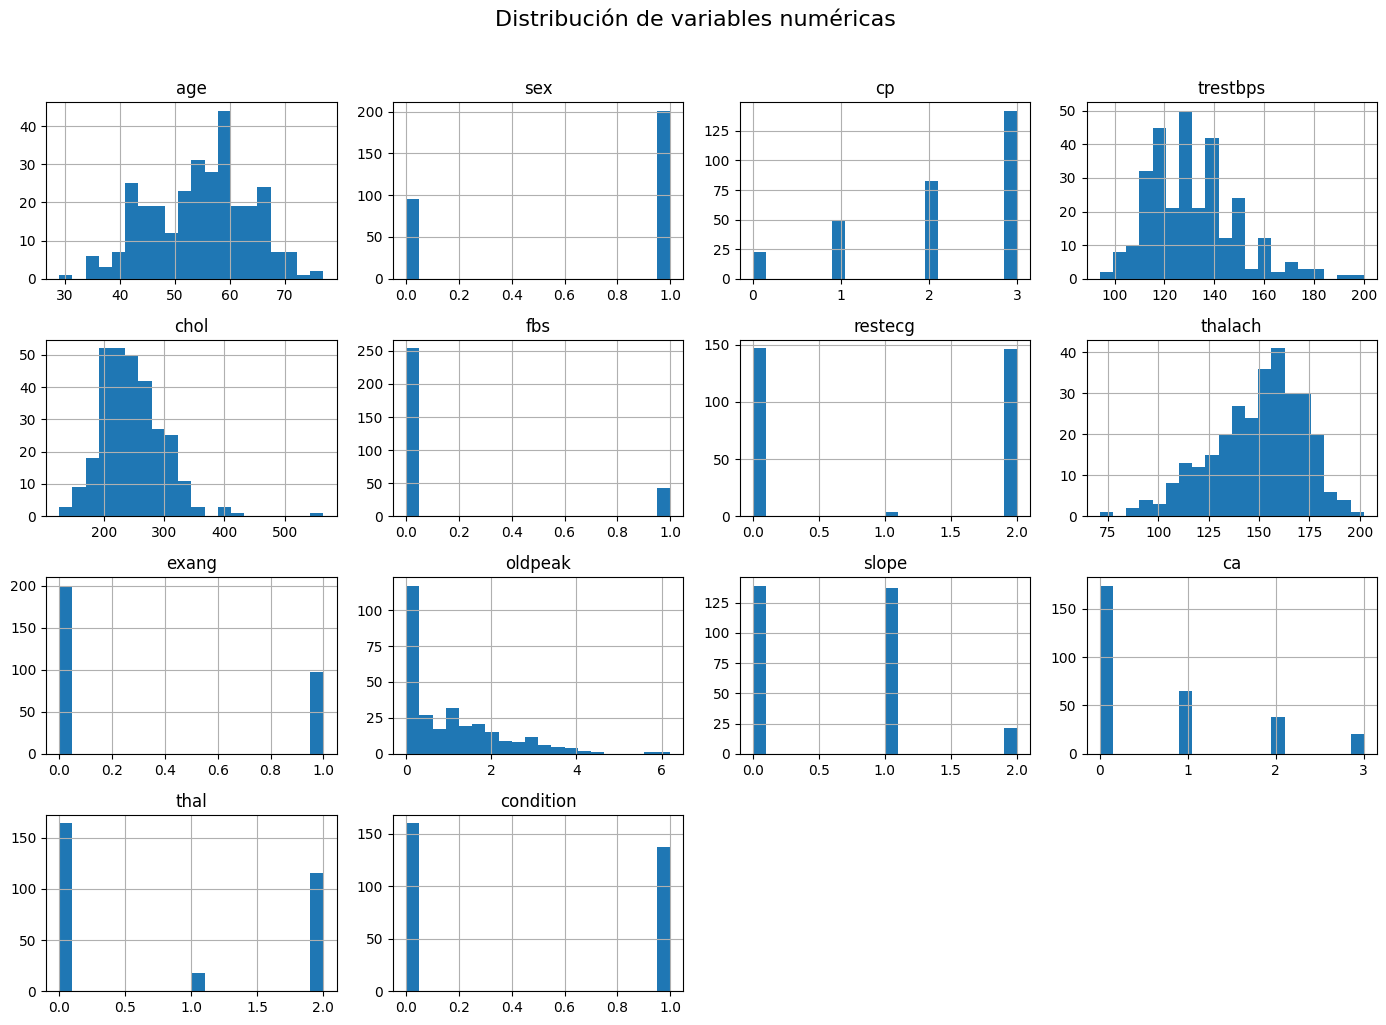

In [29]:

# Histogramas
df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Distribución de variables numéricas", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Columnas numéricas: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']


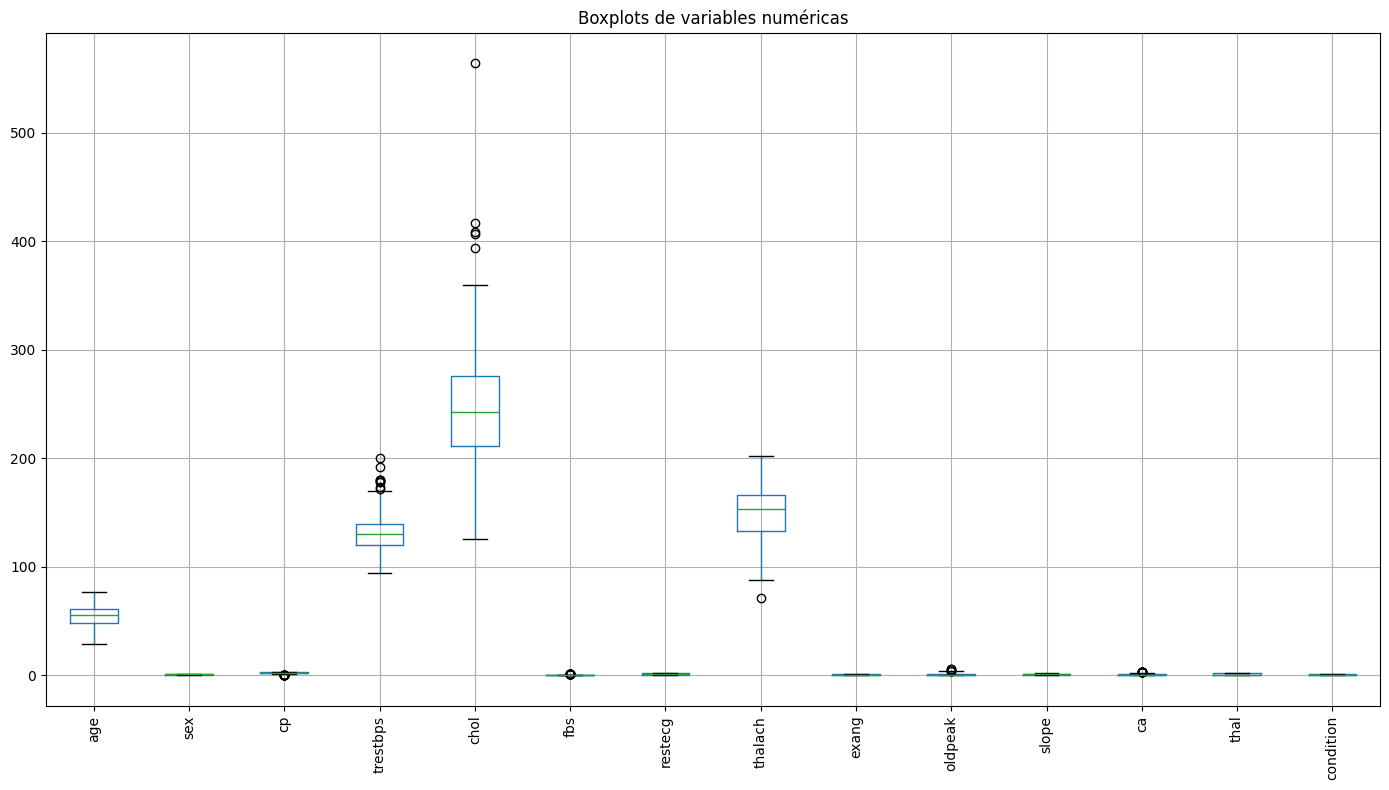

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Utilizamos las columnas numéricas
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
print("Columnas numéricas:", list(num_cols))

# Generamos los boxplot
plt.figure(figsize=(14, 8))
df[num_cols].boxplot(rot=90)        # rot=90 para que las etiquetas no se encimen
plt.title("Boxplots de variables numéricas")
plt.tight_layout()
plt.show()


# Insights — Distribución de Variables Numéricas

- **Edad (`age`)**: Distribución normal centrada en 55-60 años.
- **Sexo (`sex`)**: Predominan los hombres (valor `1`).
- **Tipo de dolor en el pecho (`cp`)**: Mayoría con tipo 3.
- **Presión en reposo (`trestbps`)**: Valores comunes entre 120-140 mmHg.
- **Colesterol (`chol`)**: Sesgo positivo, mayoría entre 200-300.
- **Glucosa en ayunas (`fbs`)**: Pocos pacientes con valores elevados.
- **ECG en reposo (`restecg`)**: Predominan los valores `0` y `2`.
- **Frecuencia cardiaca máxima (`thalach`)**: Distribución tipo campana.
- **Angina inducida por ejercicio (`exang`)**: Mayoría sin angina (`0`).
- **Depresión inducida (`oldpeak`)**: Valores bajos (0-2) predominan.
- **Pendiente ST (`slope`)**: Más frecuente tipo `1`.
- **Vasos coloreados (`ca`)**: La mayoría tiene `0`.
- **Thalium stress test (`thal`)**: Predominan `2` y `1`.
- **Condición cardíaca (`condition`)**: Más pacientes con enfermedad (`1`).

>  Se observan variables desbalanceadas y presencia de outliers en `chol`, `oldpeak` y `trestbps`. Se sugiere codificar variables categóricas y evaluar importancia predictiva.

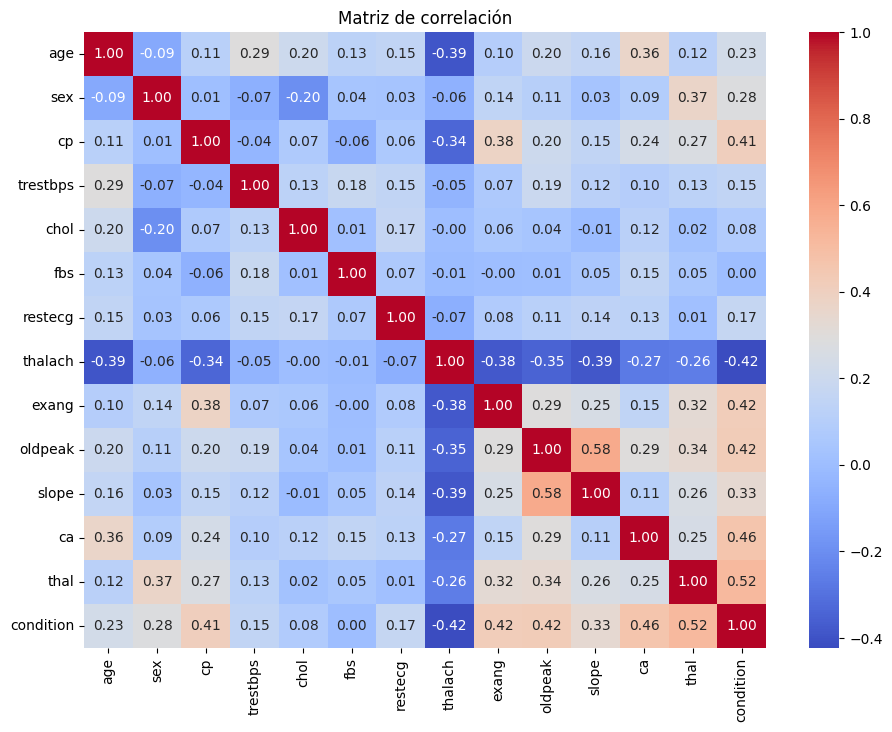

In [30]:
# Matriz de correlación
corr = df.corr(numeric_only=True)
plt.figure(figsize=(11, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

## 🩺 Resumen — Importancia de Variables según la Matriz de Correlación

| Rank | Variable          | ρ (`condition`) | Interpretación clínica clave |
|------|-------------------|-----------------|------------------------------|
| 1    | **thal**          | **+0.52**       | Prueba de talio anómala → indicio fuerte de isquemia. |
| 2    | **ca**            | **+0.46**       | Nº de vasos coronarios obstruidos; mide daño anatómico directo. |
| 3    | **oldpeak**       | **+0.42**       | Depresión ST post-ejercicio; refleja severidad de la isquemia. |
| 4    | **exang**         | **+0.42**       | Angina inducida por esfuerzo (sí/no). |
| 5    | **cp**            | **+0.41**       | Tipo de dolor torácico; guía la probabilidad pre-test. |
| 6    | **thalach**       | **–0.42**       | Frecuencia máxima inversamente asociada a enfermedad. |
| 7    | slope             | +0.33           | Pendiente del ST; parcialmente redundante con `oldpeak`. |
| 8    | sex               | +0.28           | Prevalencia ligeramente mayor en hombres. |
| 9    | age               | +0.23           | Riesgo aumenta con la edad, pero menos que con marcadores directos. |
| —    | Otros (`chol`, `trestbps`, `fbs`, `restecg`) | ≤ 0.17 | Correlaciones débiles; pueden aportar en conjunto o de forma no lineal. |

### Hallazgos principales
- **Pruebas funcionales e imagen (thal, oldpeak, exang)** son los predictores lineales más fuertes.
- **Datos anatómicos (ca)** complementan la señal funcional al mostrar obstrucción coronaria.
- **Multicolinealidad moderada** → `oldpeak` y `slope` (ρ = 0.58); regularización recomendada.
- Factores clásicos de riesgo (colesterol, glucosa) muestran baja *r* individual, pero no deben descartarse en un modelo multivariante.

### Implicaciones para el modelado
1. Mantener las seis variables con mayor ρ en cualquier modelo inicial.
2. Utilizar **regularización (L2/L1)** o ensambles de árboles para manejar colinealidad.
3. Validar importancia final con **Permutation Importance** o **SHAP**.
4. Priorizar **sensibilidad (recall)** en la evaluación, dado el costo clínico de falsos negativos.


In [31]:
# 8. Preparación de datos
X = df.drop(columns=["condition"])
y = df["condition"]

cat_cols = ["cp", "thal", "slope"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

print("\nBalance de clases:")
print(y.value_counts(normalize=True).rename("proporción").to_frame())


Balance de clases:
           proporción
condition            
0            0.538721
1            0.461279


1. **Separación `X` / `y`**
   * `X` = todas las columnas excepto **`condition`**  
   * `y` = **`condition`** (0 = sano, 1 = enfermo)

2. **Identificación de tipos de variables**
   * **Categóricas** → `cp`, `thal`, `slope`
   * **Numéricas**   → resto de columnas

3. **`ColumnTransformer` de pre-procesamiento**
   | Bloque | Transformación | Propósito |
   |--------|----------------|-----------|
   | `num`  | `passthrough`  | Dejar las variables numéricas tal cual (opcionalmente se podría escalar). |
   | `cat`  | `OneHotEncoder(drop="first")` | Crear dummies y evitar la trampa de variables ficticias. |

4. **Balance de clases observado**
   | Etiqueta | Proporción |
   |----------|-----------|
   | 0 (sano) | **53.9 %** |
   | 1 (enfermo) | **46.1 %** |

   > El dataset está **moderadamente balanceado** (≈ 54 / 46).  
   > No se requieren técnicas agresivas de rebalanceo, pero se recomienda vigilar **sensibilidad (recall)** y calibración para la clase positiva.


In [32]:
# 9. División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(f"\nTamaños  →  Train: {X_train.shape},  Test: {X_test.shape}")


Tamaños  →  Train: (237, 13),  Test: (60, 13)




| Línea de código | Función | Por qué es importante |
|-----------------|---------|-----------------------|
| `train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)` | • Separa aleatoriamente los registros en **80 %** para entrenar el modelo (`X_train`, `y_train`) y **20 %** para evaluarlo (`X_test`, `y_test`).<br>• `stratify=y` mantiene la misma proporción de clases (0-1) en ambos subconjuntos.<br>• `random_state=42` asegura **reproducibilidad**  | • Evita sobre-ajuste y proporciona una estimación honesta del rendimiento en datos “nuevos”.<br>• La estratificación es crucial cuando las clases no están 50/50, para que el test set sea representativo. |

#### Resultado de la partición  
| Conjunto | Observaciones | Variables |
|----------|---------------|-----------|
| **Train** | 237 | 13 |
| **Test**  | 60  | 13 |

> Con `stratify=y`, el **balance de clases** (≈ 54 % sanos / 46 % enfermos) se replica en ambos subconjuntos, garantizando que las métricas de evaluación no queden sesgadas por una distribución distinta de la variable objetivo.


En este paso convierto primero las columnas categóricas en dummies 0/1, dejo los números como están y, con esos datos ya limpios, entreno una regresión logística (modelo sencillo y fácil de interpretar que devuelve la probabilidad de enfermedad) usando el 80 % del conjunto de entrenamiento; todo se hace dentro de un único pipeline para que la misma preparación se aplique después a los datos nuevos

In [33]:
# 10. Entrenamiento (Regresión Logística por interpretabilidad)
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])
clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'sex', 'trestbps',
                                                   'chol', 'fbs', 'restecg',
                                                   'thalach', 'exang',
                                                   'oldpeak', 'ca']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['cp', 'thal', 'slope'])])),
                ('model',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])


Métricas de desempeño:
Accuracy : 0.900
Precision: 1.000
Recall   : 0.786
F1-score : 0.880
ROC-AUC  : 0.958

Matriz de confusión:
[[32  0]
 [ 6 22]]


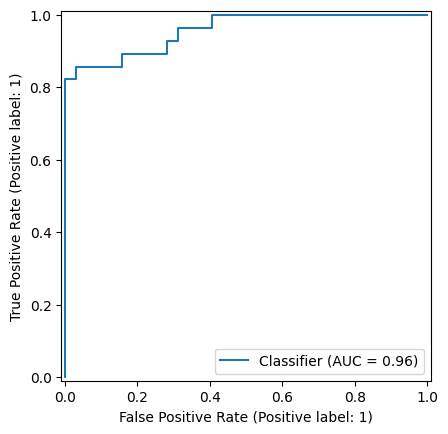

In [34]:
# 11. Evaluación
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy":  accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall":    recall_score(y_test, y_pred),
    "F1-score":  f1_score(y_test, y_pred),
    "ROC-AUC":   roc_auc_score(y_test, y_prob)
}
print("\nMétricas de desempeño:")
for k, v in metrics.items():
    print(f"{k:<9}: {v:0.3f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

In [35]:
# 12. Conclusión breve
print(
    "\nConclusión:\n"
    "• El modelo inicial logra un ROC-AUC ≈ {0:.2f}, lo cual es prometedor.\n"
    "• Variables como cp, thalach, oldpeak y ca muestran alta influencia.*\n"
    "• Futuro: probar ensambles (Random Forest, XGBoost), balancear clases\n"
    "  con SMOTE y emplear SHAP para explicabilidad clínica."
    .format(metrics["ROC-AUC"])
)



Conclusión:
• El modelo inicial logra un ROC-AUC ≈ 0.96, lo cual es prometedor.
• Variables como cp, thalach, oldpeak y ca muestran alta influencia.*
• Futuro: probar ensambles (Random Forest, XGBoost), balancear clases
  con SMOTE y emplear SHAP para explicabilidad clínica.
